In [297]:
%autosave 180

Autosaving every 180 seconds


# ShrimpSimulator
This simulator simulates the Shrimp model.

## Relevant Equations 

### Newton-Euler (equations 2.2 and 2.3)
$$\mathbf{\dot{v}^I_F} = (\mathbf{f_{aero}} + m \mathbf{g} - m \mathbf{\omega^{FI} }\times \mathbf{v^I_F})$$

$$\mathbf{\dot{\omega}^{FI}} = \mathbf{I}^{-1}(\mathbf{\tau_{aero}} - \mathbf{\omega^{FI} }\times \mathbf{I\omega^{BI}})$$

* $v_F^I$ is velocity of the center of mass of flyer frame in inertial/world frame
* $\mathbf{\omega^{FI} } = [p\ q\ r]^T$ is the angular velocity of flyer frame w.r.t. inertial
* $\mathbf{\omega^{BI} }$ is the angular velocity of body frame wrt inertial (same as flyer but with rotation about z axis).


### Blade Equations (equations 3.8)
$$[v_E^I]^E = \mathbf{R^E_F}[v^I_F]^F + \mathbf{R^E_F}[\omega^{SF}]^F \times \mathbf{R^E_F} [S_{EF}]^F + \mathbf{R^E_F}[\nu]^F$$
$$\gamma = arctan(\frac{[v_E^I]^E [\hat{z}]^E}{[v_E^I]^P [\hat{x}]^E})$$


* $[\nu]^F = [0\ 0\ \nu]^T$ is induced inflow velocity
* $\nu$ is the induced inflow velocity (Equation 3.1, thesis p.52)
* $[v_E^I]^E$ is the relative wing in the propeller frame.


### Euler Angles Convention
For euler angles, we are using the `scipy` library of `spatial.transform` with `Rotation`. https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html#scipy.spatial.transform.Rotation

This uses the capital notation `ZXY` to denote intrinsic rotations, which we will use such that the final rotation is about the rotational axis of the vehicle for readibility. This is such that the first rotation is about the Z axis, or corresponds to the yaw.
This matches the MEAM 620 project 1 convention.
Additionally, the euler angles are $\phi, \theta, \psi$, where $\phi$ is yaw.

Please use the `euler2Rotm` and `rotm2Euler` functions for converting between rotation matricies and euler angle vectors.

To convert between angular velocities $\omega$ in the body frame and euler angles:

$$\omega = \begin{bmatrix} p \\ q \\ r \end{bmatrix} = 
\begin{bmatrix} \cos\theta & 0 & -\cos\phi\sin\theta \\ 
0 & 1 & \sin\phi \\ 
-\cos\phi & 0 & \cos\phi \cos\theta
\end{bmatrix}
\begin{bmatrix} \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \end{bmatrix}
$$

## Code parameters

* camelCase unless stated otherwise
* Underscores for frames or for subscripts


## Notes
Flyer frame means that it is *not* in the frame of the propellor with the extra spin on the propellor. This is 
only relevant for the shaft propellor.

For the body drag plates, this is all in the body frame (no extra spin) so the euler angular rates are still correct, as well as the euler angles. 

Notation 
* For angular velocities: $\omega$ is a 1x3 vector, while $[\omega]$ is the tensor. We will try to have $[]$ always denote a tensor. 
* For Rotation Matricies: ${}^A R_B$ denotes a rotation from $B$ to $A$, e.g. $p_A = {}^AR_B p_B$
* For position/velocity vectors: ${}^c v_a^b$ denotes a vector from $a$ to $b$ in the $c$ frame.

### Code Vector Notation:
* Position `r_a2b_c` means the vector from a to b in the c frame. 
* Velocity `vel_a2b_c` means the vector of b velocity relative to a velocity in the c frame. So `vel_w2b_w`, since the world is stationary, that's just the b velocity in the world frame.
* Euler angles `eul_a2b` means the euler rotation from world to body, so if you apply it it transforms the world into the body frame
* Angular velocity `angvel_a2b_c` means the vector of the b angular velocity relative to a in the c frame. So angvel_w2b_f means the angular velocity of the body relative to the world frame (0) in the flyer frame. w2b_b is the same as pqr, where the velocities are defined about the body axes
* Rotation `rot_a2b` means a rotation from a frame to b frame. Applied to an a-frame vector, transforms it into a b frame vector. 


In [298]:
%matplotlib inline
import numpy as np 
from scipy.spatial.transform import Rotation as R
from enum import Enum

In [299]:
def rotm2Euler(x):
    """Rotation matrix to Euler Angles ZXY intrinsic vector for Shrimp"""
    r = R.from_dcm(x)
    return r.as_euler('ZXY')
    
def euler2Rotm(x):
    """Euler angles ZXY intrinsic vector to Rotation Matrix for Shrimp"""
    r = R.from_euler('ZXY', x)
    return r.as_dcm()

def quat2Euler(x):
    """Quaterion to Euler Angles ZXY intrinsic vector for Shrimp"""
    r = R.from_quat(x)
    return r.as_euler('ZXY')

def euler2Quat(x):
    """Euler angles ZXY intrinsic vector to Quaternion for Shrimp"""
    r = R.from_quat('ZXY', x)
    return r.as_euler()

def addYaw(eulerAngles, yaw):
    """ Add yaw in a safe way since we want to control ZXY from here"""
    return eulerAngles + np.array([yaw, 0, 0]) 

def getYaw(eulerAngle):
    return eulerAngle[0]

def getPitch(eulerAngle):
    return eulerAngle[1]

def getRoll(eulerAngle):
    return eulerAngle[2]

def angVel2EulerAngleVel(pqr, eulerZXY):
    """ Angular velocity in the body/flyerish frame to the Euler ZXY angular velocity.
        The reason it's body/flyerish depends on whether you're keeping track of the yaw
        angle in the Euler frame or not, so be careful!
        Stolen from MEAM 620
    """
    phi = eulerZXY[0]
    theta = eulerZXY[1]
    psi = eulerZXY[2]
    rot_eul2pqr = np.array([[np.cos(theta), 0, -np.cos(phi)*np.sin(theta)],
                            [0,             1, np.sin(phi)],
                            [np.sin(theta), 0, np.cos(phi)*np.cos(theta)]])
    eulVel = np.linalg.inv(rot_eul2pqr).dot(pqr)
    return eulVel

def rotateTensor(tensor, rotationMatrix):
    """ Rotate those tensors!
        Tensors (like inertia tensors) rotate as I_B = R_A^B I_B (R_A^B)^T
        Where 
        I_A is the tensor in frame A
        I_B is the tensor in frame B
        R_A^B is the rotation matrix from frame A to frame B
        
        Note this doesn't do the parallel axis theorem, so still be careful!
    """
    invRot = np.transpose(rotationMatrix)
    firstMultiplication = rotationMatrix.dot(tensor)
    return firstMultiplication.dot(invRot)

def testMath():
    eul = np.array([np.pi/2, 0, 0])
    print('eul', eul)
    k = [0,2,0]
    r = euler2Rotm(eul)
    print(r.dot(k))

    I = np.diag([1,2,3])
    

    rot = R.from_euler('z', 45, degrees='true')
    rotm = R.as_dcm(rot)
    print(r.dot(k))
    print(rotm)
    I = np.diag([1,2,3])
    rotateTensor(I, rotm)
    yaw = np.pi/2
    print('eul', eul)
    print("Should be pi, 0, 0", addYaw(eul,yaw))

testMath()

eul [1.57079633 0.         0.        ]
[-2.0000000e+00  4.4408921e-16  0.0000000e+00]
[-2.0000000e+00  4.4408921e-16  0.0000000e+00]
[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]
eul [1.57079633 0.         0.        ]
Should be pi, 0, 0 [3.14159265 0.         0.        ]


## Relative Wind
Calculating the relative wind is pretty similar to the blade equations above. 
We want to take the given blade section, and then calculate the relative wind vector in the propellor frame. 

![relativewind](../lib/relative_wind.png)

The propellor (E) frame described:

![propellorFrame](../lib/element_frame.png)

Assumptions: No exterior wind disturbance.

The relative wind in this case comes from three components, which we can sum independently:
* **The body velocity**. This is simply the velocity of the body frame w.r.t. the world frame in the world frame $^w v_w^b$ rotated to the element frame $^e v_w^b$. 

$${}^e v_w^b = {}^e R_b {}^b R_w {}^w v_w^b$$

* **The inflow velocity**. The inflow velocity $\nu$ adds simply another component in the negative z-axis, coming from the ducted interaction:

$${}^e v_{inflow} = [0,\ 0,\ -\nu]^T$$

* **The body angular velocity**. The angular velocity in the body frame $\hat{\omega}^b$ needs to be translated to a linear velocity at the element point. The position vector from the body origin (center of mass) to the element origin in the body frame is ${}^b p_b^e$.
${}^b p_b^e = [r \cos\kappa,\ r \sin\kappa,\ h]^T$, where $h$ is the height (z-axis distance) from the cg to the propellor center, $r$ is the radius of the element, and $\kappa$ is the angle of the propellor with respect to the body x axis. 

For calculating the angle of the propellor $\kappa$, we have to take a different approach for body vs. shaft blades.

For the body blades, the first blade is always aligned with the body x-axis and all further blades are spaced evenly around the center of the body. 

The linear velocity of the element relative to the body in the body frame is ${}^b v_e^b = {}^b \omega^b \times {}^b p_b^e$. 

However, if the blades are rotating independently of the body rotation, with some speed $\dot{\psi}$, then there is an extra rotation of the element in the body frame: ${}^b \omega_e = [0,\ 0,\ \dot{\psi}]^T$, such that:

$${}^w v_e^b = {}^w R_b \left(({}^b \omega_b + {}^b \omega_e) \times {}^b p_b^e\right)$$

For the body blade $\dot{\psi}$ is zero, while otherwise it is the propellor spin rate in radians per second.

A note on $\kappa$ for the shaft blade:
For the shaft blades, they are spinning at roughly 3-8 revolutions per second. That is just barely fast enough that we should not track the position of each blade to do the calculation, but instead do the integral. TODO. 

The total relative wind is then:

$${}^e v_{wind} = - {}^e v_w^b - {}^e v_b^e + {}^e v_{inflow}$$

### Calculating rotation matricies
Assuming we know our XYZ intrinsic euler angles, ${}^b R_w$ is simply the transformation from euler to rotation. The rotation from body to element, ${}^e R_b$ is the rotation by the propellor angle. In the picture above, the propellor angle is 0 (the propellor y-axis aligns with the body x-axis), so ${}^e R_b$ is a rotation about the body $z$ axis by $\pi/2$. 

### Calculating angular velocity
The angular velocities we are keeping track of are those of the body frame in the world frame: ${}^w \omega_b = [p\ q\ r]^T$. To get it in the body frame, I am pretty sure you can just rotate it. But to go from the euler angle rotations:

$$\begin{bmatrix} p \\ q \\ r \end{bmatrix} = \begin{bmatrix} \cos \theta & 0 & \cos\phi \sin\theta \\ 0 & 1 & \sin\phi \\ \sin\theta & 0 & \cos\phi \cos\theta \end{bmatrix} 
\begin{bmatrix} \dot{\phi} \\ \dot{\theta} \\ \dot{\psi}\end{bmatrix}$$

In [300]:
def getRelativeWind(bladeIndex, numBlades, bladeRadius, vel_w2b_w, 
                    rot_w2b, angvel_w2b_b, inflowVelocity, height_b2e,
                    yawDot_b2e):
    """
    Returns relative wind angle as well as the wind angle vector for 
    the given quantities
    
    Return values:
    relativeWind_e : the relative wind in the propellor frame
    relWindAngleGamma: the wind angle relative to the propellor blade disk angle
    r_b2e_b: the vector from the body to the element in the body frame
    rot_b2e: the rotation matrix from the body to element frame 
    
    Arguements:
    bladeIndex: the index of the blade to be used. Assumes blade 0 is aligned with the 
    x-axis of the body
    numBlades: total number of blades, assuming equal spacing
    bladeRadius: the radius to do this overall calculation
    vel_w2b_w: velocity of the body relative to the world velocity in the world frame
    rot_w2b: DCM of world to body
    angvel_w2b_b: angular velocity of body relative to world velocity in body axes (pqr)
    inflowVelocity: also called nu - scalar amount of inflow velocity
    height_b2e: the distance from body to element along the body z axis (up is positive)
    yawDot_b2e: speed of element relative to body about the body z-axis (spin rate)
    
    Notation:
    _e is prop element frame
    _b is the body frame (about the center of gravity)
    _w is world/inertial frame
    
    """
    # Calculate Rotation Matricies
    propellor_angle = bladeIndex/numBlades * 2 * np.pi
    rot_b2e = R.from_euler('Z', propellor_angle + np.pi/2).as_dcm()
    
    # Body Velocity Calculation
    vel_w2b_b = rot_w2b.dot(vel_w2b_w)
    vel_w2b_e = rot_b2e.dot(vel_w2b_b)
    
    # Inflow velocity Calculation
    # it is always in the negative z direction
    vel_inducedInflow_e = np.array([0, 0, -inflowVelocity])
    
    # Velocity from rotational component Calculation
    # Calculate the vector from the cg to the element 
    pos_x_blade = bladeRadius*np.cos(propellor_angle + np.pi/2)
    pos_y_blade = bladeRadius*np.sin(propellor_angle + np.pi/2)
    r_b2e_b = np.array([pos_x_blade, pos_y_blade, height_b2e])
    
    # Calculate the angular velocity in the body frame
    angvel_b2e_b = np.array([0, 0, yawDot_b2e])
    # Total angular velocity of the propellor is body + prop
    angvel_w2e_b = angvel_b2e_b + angvel_w2b_b
    
    vel_b2e_b = np.cross(angvel_w2e_b, r_b2e_b)
    vel_b2e_e = rot_b2e.dot(vel_b2e_b)
    
    # Sum all forces together
    relativeWind_e = -(vel_w2b_e + vel_b2e_e) + vel_inducedInflow_e
    relWindAngleGamma = np.arctan2(relativeWind_e[2], relativeWind_e[0])

    return (relativeWind_e, relWindAngleGamma, r_b2e_b, rot_b2e)

In [301]:
def testRelativeWind():
    # Test for relative wind 
    eul_w2b = np.pi/180*np.array([0,0,0]) # ZXY
    rot_w2b = euler2Rotm(eul_w2b) 

    numBlades = 2
    bladeRadius = 0.1
    bladeIndex = 1
    vel_w2b_w = np.array([0, 10, 10])
    angvel_w2b_b = np.array([0.0, 0.0, 0.0])
    inflowVelocity = 0
    height_b2e = 2
    yawDot_b2e = 0

    # Using XYZ euler angles such that the last angle Z is the correct psi angle
    (relWind, gamma, _, _) = getRelativeWind(bladeIndex, numBlades, bladeRadius, vel_w2b_w, 
                                            rot_w2b, angvel_w2b_b, inflowVelocity, height_b2e,
                                            yawDot_b2e)

    print('gamma', gamma*180/np.pi)
    print('relwind', relWind)

testRelativeWind()

gamma -135.0
relwind [-1.00000000e+01  2.22044605e-15 -1.00000000e+01]


## Lift and Drag
Note that lift is POSITIVE in this model. Z is up. 
$$L = \frac{1}{2} \rho V^2 C_L S$$
$$D = \frac{1}{2} \rho V^2 C_D S$$
Where 
* $C_L, C_D$ are lift and drag coefficients, functions of angle of attack ($alpha$)
* $S$ is wing area. 
* $\rho$ is air density 
* $V$ is velocity at the wing element

In [302]:
def getAngleOfAttack(bladePitch, relWindAngleGamma):
    """ Returns angle of attack between -pi and pi"""
    unwrapped_angle = bladePitch + relWindAngleGamma
    return (unwrapped_angle + np.pi) % (2 * np.pi ) - np.pi

def clFlatPlate(alpha):
    """ Coeff of lift for a Flat Plate """
    return 2.*np.sin(alpha)*np.cos(alpha)

def cdFlatPlate(alpha):
    """ Coeff of drag for a Flat Plate """
    return 2.*np.sin(alpha)**2.0

def cmFlatPlate(alpha):
    """ Coeff of pitch moment for a Flat Plate """
    return 0.0

def getLiftDragElement(elementWidth, chord, rho, relWind_e, alpha):
    """ Returns magnitude of lift and drag
    Arguements:
    elementWidth: the width of the blade section 
    chord: airfoil chord
    rho: air density
    relWind_e : relative wind in the propellor frame
    alpha: angle of attack of section
    Returns:
    (lift, drag) scalars
    """
    # velocity only incorporates the x and z components in the wind frame 
    speed = relWind_e.dot([1,0,1])    
    coeffLift = clFlatPlate(alpha)
    coeffDrag = cdFlatPlate(alpha)
    quantity = 0.5*speed*speed*chord*elementWidth*rho
    lift = quantity * coeffLift
    drag = quantity * coeffDrag
    return (lift, drag)

In [303]:
def rpm2RadiansPerSecond(x:float) -> float:
     return 0.10472 * x

In [304]:
class PropellorType(Enum):
    SHAFT = 1
    BODY = 2

class BladeElementParameters:
    def __init__(self, rho, pitch, width, radius, chord, index, numBlades, 
                 height_b2e, inflowVel, yawDot_b2e):
        self.rho = rho
        self.pitch = pitch 
        self.width = width  # this is in the radial direction (strip model width)
        self.radius = radius  # this should probably "middle" of the overall radius width 
        self.chord = chord
        self.index = index # Blade Index out of n blades
        self.numBlades = numBlades # total number of blades. A normal prop has 2
        self.height_b2e = height_b2e # scalar [m]
        self.inflowVel = inflowVel # Inflow velocity for this element. Scalar [m/s]
        self.yawDot_b2e = yawDot_b2e # spin velocity of prop about body z axis for this element. Scalar [m/s] 

class PropellorParameters:
    """Parameters of all blades in the propellor
       Assumes propellor center is aligned in the z-axis with the body center of mass.
    """
    def __init__(self, numBlades, pitchRootTip, radiusRootTip, chordRootTip, 
                 height_b2p, propType):
        self.numBlades = numBlades 
        self.pitchRootTip = pitchRootTip # Tuple of blade pitch, (root, tip)
        self.radiusRootTip = radiusRootTip # Tuple, (root, tip)
        self.chordRootTip = chordRootTip # Tuple, (root, tip)
        self.height_b2p = height_b2p # Z-axis distance from cg to propellor, +z is up
        self.propType = propType # PropellorType Enum

class BatteryParameters:
    """Parameters for a battery"""
    def __init__(self, voltage, resistance):
        self.voltage = voltage  # nominal voltage
        self.resistance = resistance  # internal resistance, assumed constant heh
       
class MotorParameters:
    """Parameters for a motor"""
    def __init__(self, K_t, resistance):
        self.K_t = K_t  # Eletromotive forceconstant, or 1/K_v
        self.resistance = resistance  # stator resistance, assumed constant heh
        
class ShrimpParameters:
    """ Parameters of Shrimp Aircraft.
    """
    def __init__(self, bodyPropParams, shaftPropParams, bodyMass, Ixx, Iyy, Izz, 
                 propIxx, propIyy, propIzz, rho, motorParams, batteryParams, propMass):
        self.bodyPropParams = bodyPropParams
        self.shaftPropParams = shaftPropParams
        self.bodyMass = bodyMass  # mass of everything attached to stator, so not rotor and prop
        self.inertia_b = np.diag([Ixx, Iyy, Izz])  # body Inertia without prop inertia
        self.propInertia_b = np.diag([propIxx, propIyy, propIzz])  
        self.rho = rho # Air density
        self.motorParams = motorParams 
        self.batteryParams = batteryParams
        self.propMass = propMass
        
def getRotsFromEuler(euler_w2b, yaw_f2b):
    rot_f2b = R.from_euler('z', yaw_f2b).as_dcm()
    rot_w2b = euler2Rotm(euler_w2b)
    rot_b2w = np.transpose(rot_w2b)
    rot_f2w = rot_f2b.dot(rot_b2w)
    return (rot_f2b, rot_w2b, rot_b2w, rot_f2w)

class ShrimpState:
    """ Shrimp state object. Stores state in a clear format, and also converts 
        the clear format to a numpy vector for ODE integration.
    """
    def __init__(self, r_w2b_w, vel_w2b_w, euler_w2b, angvel_w2b_b, inflowVel, 
                 yaw_b2p, yaw_f2b, yawDot_b2p, yawDot_f2b, rot_f2b, rot_b2w, rot_w2b, rot_f2w,
                 euler_w2f, angvel_w2f_f, angvel_f2b_f):
        self.r_w2b_w = r_w2b_w  # np.array 3x1 position vector from world origin to body/cg
        self.vel_w2b_w = vel_w2b_w  # np.array 3x1 velocity vector from world origin to body/cg
        self.euler_w2b = euler_w2b  # np.array 3x1 euler from world to body frame
        self.angvel_w2b_b = angvel_w2b_b  # np.array 3x1 angular velocity of the body in the body frame 
        self.inflowVel = inflowVel # scalar inflow velocity adjustment due to duct on the shaft propellor [m/s]
        self.yaw_b2p = yaw_b2p # the angle from the stator/body to the rotor/propellor
        self.yaw_f2b = yaw_f2b # the angle from the flyer frame to the body frame 
        self.yawDot_b2p = yawDot_b2p # the speed of the spin of the propellor relative to the body/stator. Scalar [rad/s]
        self.yawDot_f2b = yawDot_f2b # the speed of the spin of the body relative to the flyer frame. Scalar [rad/s]
        self.rot_f2b = rot_f2b
        self.rot_b2w = rot_b2w
        self.rot_w2b = rot_w2b
        self.rot_f2w = rot_f2w
        self.euler_w2f = euler_w2f
        self.angvel_w2f_f = angvel_w2f_f
        self.angvel_f2b_f = angvel_f2b_f
    
    @classmethod
    def fromVecState(cls, r_w2b_w, vel_w2b_w, euler_w2b, angvel_w2b_b, inflowVel, 
                     yaw_b2p, yaw_f2b, yawDot_b2p, yawDot_f2b):
        (rot_f2b, rot_w2b, rot_b2w, rot_f2w) = getRotsFromEuler(euler_w2b, yaw_f2b)
        euler_w2f = rotm2Euler(np.transpose(rot_f2w))
        rot_b2f = np.transpose(rot_f2b)
        angvel_f2b_f = np.array([0, 0, yawDot_f2b])
        angvel_w2b_f = rot_b2f.dot(angvel_w2b_b)
        angvel_b2f_f = -angvel_f2b_f
        angvel_w2f_f = angvel_w2b_f + angvel_b2f_f
        return cls(r_w2b_w, vel_w2b_w, euler_w2b, angvel_w2b_b, inflowVel, 
                   yaw_b2p, yaw_f2b, yawDot_b2p, yawDot_f2b, rot_f2b, rot_b2w, rot_w2b, rot_f2w,
                   euler_w2f, angvel_w2f_f, angvel_f2b_f)
        
    @classmethod
    def fromOdeState(cls, odeState):
        """ Converts from vector to this object.
            odeState[0] = x body position in world frame
            odeState[1] = y body position in world frame
            odeState[2] = z body position in world frame
            odeState[3] = x body velocity in world frame
            odeState[4] = y body velocity  in world frame
            odeState[5] = z body velocity  in world frame
            odeState[6] = Z ZXY euler angle in flyer frame (yaw)
            odeState[7] = Y ZXY euler angle in flyer frame
            odeState[8] = X ZXY euler angle in flyer frame
            odeState[9] = p is x roll rate in flyer frame
            odeState[10] = q is y pitch rate in flyer frame
            odeState[11] = r is z yaw rate in flyer frame
            odeState[12] = yawDot_f2b is body yaw rate wrt flyer frame
            odeState[13] = yawDot_b2p is the prop speed wrt body frame (stator frame)
            odeState[14] = yaw_f2b from flyer to stator/body frame
            odeState[15] = yaw_b2p from stator/body to rotor/prop frame
        """
        r_w2b_w = odeState[0:3]
        vel_w2b_w = odeState[3:6]
        euler_w2f = odeState[6:9]
        angvel_w2f_f = odeState[9:12]
        yawDot_f2b = odeState[12]
        yawDot_b2p = odeState[13]
        yaw_f2b = odeState[14]
        yaw_b2p = odeState[15]
        euler_w2b = addYaw(euler_w2f, yaw_f2b)
        (rot_f2b, rot_w2b, rot_b2w, rot_f2w) = getRotsFromEuler(euler_w2b, yaw_f2b)
        angvel_f2b_f = np.array([0, 0, yawDot_f2b]) # Angvel of the in flyer frame
        angvel_w2b_f = angvel_w2f_f + angvel_f2b_f
        angvel_w2b_b = rot_f2b.dot(angvel_w2b_f)
        inflowVel = 0
        return cls(r_w2b_w, vel_w2b_w, euler_w2b, angvel_w2b_b, inflowVel, 
                   yaw_b2p, yaw_f2b, yawDot_b2p, yawDot_f2b, rot_f2b, rot_b2w, rot_w2b, rot_f2w,
                   euler_w2f, angvel_w2f_f, angvel_f2b_f)

def defaultShaftPropParams():
    """ Parameters for Cheerson 
        Data from propellor_cheerson_cx10.m
    """
    numBlades = 2
    # TODO: do pitches/radius with interpolable sections 
    pitchRootTip = (0.175, 0.18) # In code this is Beta
    chordRootTip = (3.22e-3, 4.12e-3) 
    radiusRootTip = (0, 0.0146)
    height_b2p = -1.55/1000 # Piccolissimo_V11, positive is UP
    propType = PropellorType.SHAFT
    return PropellorParameters(numBlades, pitchRootTip, radiusRootTip, chordRootTip, 
                               height_b2p, propType)

    
def defaultBodyPropParams():
    """ Parametersfor body_Piccolissimo_V11"""
    numBlades = 6
    # TODO: do pitches/radius with interpolable sections 
    pitchRootTip = (0.15359, 0.7927) 
    chordRootTip = (0.0135, 0.0054) 
    radiusRootTip = (0, 19.16e-3)
    height_b2p = 2.56/1000 # Piccolissimo_V11, positive is UP 
    propType = PropellorType.BODY
    return PropellorParameters(numBlades, pitchRootTip, radiusRootTip, chordRootTip, 
                               height_b2p, propType)


def defaultBatteryParams():
    """ Default battery Parameters
        From PiccolissimoControl.m
    """
    voltage = 3.7
    resistance = 2
    return BatteryParameters(voltage, resistance)

def defaultMotorParams():
    """ From motor_cheerson_cx10.m"""
    resistance = 1.97
    K_t = 1/(20500*2*np.pi/60)  #Nm/A
    return MotorParameters(K_t, resistance)

def defaultShrimpParams():
    """ Piccolissimo V11 essentially"""
    bodyPropParams = defaultBodyPropParams()
    shaftPropParams = defaultShaftPropParams()
    massBody = 4.22e-3
    inertiaAdjustment = 2.5
    Ixx = inertiaAdjustment * 383e-9
    Iyy = inertiaAdjustment * 439e-9
    Izz = inertiaAdjustment * 697e-9
    
    # Taken from propellor_cheerson_cx10.m Though this describes the rotor mass/inertia
    # as well
    propIxx = 3.95e-9
    propIyy = 6.31e-9
    propIzz = 3.21e-9
    propMass = 0.25e-3
    
    rho = 1.225
    motorParams = defaultMotorParams()
    batteryParams = defaultBatteryParams()
    return ShrimpParameters(bodyPropParams, shaftPropParams, massBody, Ixx, Iyy, Izz, 
                            propIxx, propIyy, propIzz, rho, motorParams, batteryParams, propMass)
    
def dummyShrimpState():
    r_w2b_w = np.array([6, 20, 1])
    vel_w2b_w = np.array([1, 2, 3])
    euler_w2b = np.array([2, 3, 5]) * np.pi/180.
    angvel_w2b_b = np.array([1, 23, 8])
    inflowVel = 0
    yaw_b2p = 0.2
    yaw_f2b = 0.3
    yawDot_f2b = rpm2RadiansPerSecond(10)
    yawDot_b2p = rpm2RadiansPerSecond(500)
    state = ShrimpState.fromVecState(r_w2b_w, vel_w2b_w, euler_w2b, angvel_w2b_b, inflowVel, 
                                     yaw_b2p, yaw_f2b, yawDot_b2p, yawDot_f2b)
    return state

def dummyOdeStateVsShrimpState():
    s = dummyShrimpState()
    odeState = np.zeros(16)
    odeState[0:3] = s.r_w2b_w 
    odeState[3:6] = s.vel_w2b_w 
    odeState[6:9] = s.euler_w2f 
    odeState[9:12] = s.angvel_w2f_f 
    odeState[12] = s.yawDot_f2b 
    odeState[13] = s.yawDot_b2p 
    odeState[14] = s.yaw_f2b 
    odeState[15] = s.yaw_b2p 
    state = ShrimpState.fromOdeState(odeState)
    return (s,state)

temp = dummyShrimpState()
temp2 = np.zeros(16)
temp3 = ShrimpState.fromOdeState(temp2)
temp4 = defaultShrimpParams()
(s1, s2) = dummyOdeStateVsShrimpState()
print('The following should be close to zero, if not zero: ')
print('s.r_w2b_w: ', (s1.r_w2b_w - s2.r_w2b_w))
print('s.vel_w2b_w: ', (s1.vel_w2b_w - s2.vel_w2b_w))
print('s.euler_w2f: ', (s1.euler_w2f - s2.euler_w2f))
print('s.angvel_w2f_f: ', (s1.angvel_w2f_f - s2.angvel_w2f_f))
print('s.yawDot_f2b: ', (s1.yawDot_f2b - s2.yawDot_f2b))
print('s.yawDot_b2p: ', (s1.yawDot_b2p - s2.yawDot_b2p))
print('s.yaw_f2b: ', (s1.yaw_f2b - s2.yaw_f2b))
print('s.yaw_b2p: ', (s1.yaw_b2p - s2.yaw_b2p))

The following should be close to zero, if not zero: 
s.r_w2b_w:  [0. 0. 0.]
s.vel_w2b_w:  [0. 0. 0.]
s.euler_w2f:  [0. 0. 0.]
s.angvel_w2f_f:  [0. 0. 0.]
s.yawDot_f2b:  0.0
s.yawDot_b2p:  0.0
s.yaw_f2b:  0.0
s.yaw_b2p:  0.0


In [305]:
def getElementForceMoment(params, state):
    """Returns force and moment vectors in the flyer frame 
    Assumes the element radius is the radius at the center of the width. 
    The width is only used in a surface area calculation. 
    Arguments:
        params (BladeElementParameters)
        state (ShrimpState)
    """
    # TODO: refactor with shorter names
    rho = params.rho
    bladeIndex = params.index
    bladeRadius = params.radius
    vel_w2b_w = state.vel_w2b_w
    angvel_w2b_b = state.angvel_w2b_b
    inflowVelocity = params.inflowVel
    height_b2e = params.height_b2e
    yawDot_b2e = params.yawDot_b2e
    euler_w2b = state.euler_w2b
    numBlades = params.numBlades
    
    rot_b2w = state.rot_b2w
    rot_w2b = state.rot_w2b
    
    # TODO: make call less ugly. Maybe move r_b2e_b and rot_b2e into the creation of the blade element object
    (relativeWind_e, gamma, r_b2e_b, rot_b2e) = getRelativeWind(bladeIndex, numBlades, 
                                                                bladeRadius, vel_w2b_w, 
                                                                rot_w2b, angvel_w2b_b, 
                                                                inflowVelocity, height_b2e,
                                                                yawDot_b2e)
    
    alpha = getAngleOfAttack(gamma, params.pitch)
    (lift, drag) = getLiftDragElement(params.width, params.chord, rho, relativeWind_e, alpha)
    
    # Forces in the propellor frame
    normalForce_e = lift*np.cos(gamma) + drag*np.sin(gamma)
    tangentialForce_e = -lift*np.sin(gamma) + drag*np.cos(gamma)
    
    # Z-axis is up! 
    forces_e = np.array([-tangentialForce_e, 0, normalForce_e])
    
    rot_e2b = np.transpose(rot_b2e)
    forces_b = rot_e2b.dot(forces_e)
    moments_b = np.cross(forces_b, r_b2e_b)
    
    return(forces_b, moments_b)
    
def testBladeElement(radius, chord, pitch, width):
    rho = 1.225
    bladeIndex = 1
    numBlades = 2
    height_b2e = 0.01
    
    inflowVel = 1
    yawDot_b2e = rpm2RadiansPerSecond(500)
    # Set up this particular propellor element
    bladeParams = BladeElementParameters(rho, pitch, width, radius, chord, bladeIndex,
                                         numBlades, height_b2e, inflowVel, yawDot_b2e)
    
    state = dummyShrimpState()
    (forces_b, moments_b) = getElementForceMoment(bladeParams, state) 
    return (forces_b, moments_b)
    
def testBlade():
    n = 5 # The number of sections to split the blade into for element theory
    radiusRoot = 0
    radiusTip = 0.1 # maximum blade radius / tip to root
    width = (radiusTip-radiusRoot)/n
    chordRoot = 0.1 # Chord at the root of the blade
    chordTip = 0.2 # Chord at the tip of the blade
    pitchRoot = 0*np.pi/180
    pitchTip = 15*np.pi/180
    
    radii = np.linspace(radiusRoot, radiusTip, n)
    chords = np.linspace(chordRoot, chordTip, n)
    pitches = np.linspace(pitchRoot, pitchTip, n)
    
    forceMomentTuples = [testBladeElement(r, c, p, width) for (r,c,p) in zip(radii, chords, pitches)]

    forces = sum([f for f,_ in forceMomentTuples])
    moments = sum([m for _,m in forceMomentTuples])
    print('Forces', forces)
    print('Moments', moments)
testBlade()

Forces [-2.01736415e-17  9.08540043e-02 -5.84709257e-01]
Moments [-3.32583171e-02  6.47808626e-18  2.90011542e-18]


# ODE integration
For the ODE, we need the equations of motion of the system. We're going to do this in the body frame so we have a constant inertial tensor, and never have to "pay the price". In particular Piccoli does this as well as he does the ODE integration in the flyer frame, which I think ignores some math in terms of how angular velocities rotate as they are integrated (see this stackexchange: https://math.stackexchange.com/questions/773902/integrating-body-angular-velocity).

I think the right thing to do is integrate in the world frame. This makes the ODE more stable, at the penalty of a time-varying inertial tensor. 

Reproducing the Newton Euler Equations here:

# Newton-Euler (equations 2.2 and 2.3)
$$\mathbf{\dot{v}^I_F} = (\mathbf{f_{aero}} + m \mathbf{g} - m \mathbf{\omega^{FI} }\times \mathbf{v^I_F})$$

$$\mathbf{\dot{\omega}^{FI}} = \mathbf{I}^{-1}(\mathbf{\tau_{aero}} - \mathbf{\omega^{FI} }\times \mathbf{I\omega^{BI}})$$

* $v_F^I$ is velocity of the center of mass of flyer frame in inertial/world frame
* $\mathbf{\omega^{FI} } = [p\ q\ r]^T$ is the angular velocity of flyer frame w.r.t. inertial
* $\mathbf{\omega^{BI} }$ is the angular velocity of body frame wrt inertial (same as flyer but with rotation about z axis).



## On Flyer vs Body frame:
In Piccoli's code, the transformation between body and flyer frame is `Rb_f`, defined in `ComputeAero.m`. It is a rotation around the z axis by (yaw + prop angle). He does this weird thing where he post-multiplies a body force by `Rb_f` to get the force in the flyer frame. This is a transformation of a row matrix form the flyer frame into the body frame, so `Rb_f` properly is a rotation from the flyer frame into the body frame. 

* `b*Rb_f` yields a column in the flyer frame, b is a row vector
* `Rb_f*f` yields a column in the body frame, f is a column vector
* `f*Rb_f'` yields a row vector in the body frame, f is a row vector

## Newton's equations:
There is one concern of doing things in the body frame that timestep/numerical issue will come up if the integration is too slow, but we'll have to check that later. TODO. The Flyer frame is ill-defined when it says it neglects yaw.

We'll add up all the forces in the body frame however, and then integrate them in the world frame.

The following is all in the Body frame:
$$\mathbf{{}^b\dot{v}_w^b} = (\mathbf{{}^b f_{aero}} + m {}^b \mathbf{g} - m \mathbf{{}^b\omega^{w} }\times \mathbf{{}^b v_b^w})/m$$

### Other notes from Piccoli's simulator
Piccoli basically takes the inflow velocity $\nu$ tobe constant, as $\dot{\nu}$ almost always equals 0.

### Motor calculations
Piccoli calculates the motor moments using the following equations:
$$i_m = \frac{v_{clamp} pwm -K_{t_m}*(\omega_r)}{pwm^2 R_b+R_m}$$
where
* $i_m$ is motor current
* $R_b$ is battery resistance
* $R_m$ is motor resistance
* $K_{t_m}$ is eletromotive force constant, or $1/K_v$ 
* $pwm$ is motor pwm
* $\omega_r$ is the rotor speed wrt stator, or rather the "prop speed"


* $^F M_{motor} = R_P^F \begin{bmatrix}0 \\ 0 \\ K_{t_m} i_m \end{bmatrix} $
In this case, the moment only exists in the z axis anyway, and prop frame to flyer should be a z-axis rotation, so we can skip it for sanity. 

In generla the $R_P^F$ should be benign for aerodynamic forces.


### Integrating Angular velocity
Apparently this isn't as easy as hitting integrate:

https://www.ashwinnarayan.com/post/how-to-integrate-quaternions/
https://math.stackexchange.com/questions/773902/integrating-body-angular-velocity
 https://physics.stackexchange.com/questions/351435/newton-euler-equations-in-frame-not-centered-at-center-of-mass

In [306]:
def getBladeForceMoment(propParams, shrimpParams, state, bladeIndex):
    """Get the force moment of a single blade.
       Splits up the blade into n sections and evaluates a strip model for each
       section. Also decides inflow velocity and angular velocity based off of whether 
       it is the body or shaft propellor
       Arguments:
           propParams: PropellorParameters
           shrimpParams: ShrimpParameters
           state: ShrimpState
           bladeIndex: index of the blade in the propellor
    """
    n = 5 # The number of sections to split the blade into for element theory
    (radiusRoot, radiusTip) = propParams.radiusRootTip
    width = (radiusTip-radiusRoot)/n
    
    pitches = np.linspace(propParams.pitchRootTip[0], propParams.pitchRootTip[1], n)
    radii = np.linspace(radiusRoot, radiusTip, n)
    chords = np.linspace(propParams.chordRootTip[0], propParams.chordRootTip[1], n)
   
    # Assign propellor specific characteristics
    if propParams.propType == PropellorType.SHAFT:
        inflowVel = state.inflowVel
        yawDot_b2p = state.yawDot_b2p
    elif propParams.propType == PropellorType.BODY:
        inflowVel = 0
        yawDot_b2p = 0
    else:
        raise Exception('Using unimplemented PropellorType!')
    
    def getThisElemForceMoment(pitch, radius, chord):
        elementParams = BladeElementParameters(shrimpParams.rho, pitch, width, radius,
                                               chord, bladeIndex, propParams.numBlades, 
                                               propParams.height_b2p, inflowVel, 
                                               yawDot_b2p)
        return getElementForceMoment(elementParams, state)
    
    forceMomentTuples_b = [getThisElemForceMoment(p, r, c) 
                           for (p, r, c) in zip(pitches, radii, chords)]
    forces_b = sum([f for f,_ in forceMomentTuples_b])
    moments_b = sum([m for _,m in forceMomentTuples_b])
    return (forces_b, moments_b)
    
def getPropForceMoment(propParams, shrimpParams, state):
    """Computes the force across all blades in the propellor
        Arguments:
        propParams: PropellorParameters to be iterated over
        shrimpParams: ShrimpParameters
        state: ShrimpState 
    """
    forceMomentTuples_b = [getBladeForceMoment(propParams, shrimpParams, state, i)
                           for i in range(propParams.numBlades)]
    forces_b = sum([f for f,_ in forceMomentTuples_b])
    moments_b = sum([m for _,m in forceMomentTuples_b])
    return (forces_b, moments_b)
    
def testPropForceMoment():
    propParams = defaultBodyBladeParams()
    shrimpParams = defaultShrimpParams()
    state = dummyShrimpState()
    
    (f, m) = getPropForceMoment(propParams, shrimpParams, state)
    print('Forces: ', f)
    print('Moments: ', m)

testPropForceMoment()
    

Forces:  [ 0.00165273  0.00289522 -0.01263566]
Moments:  [-3.96729212e-05 -3.04565279e-05 -8.50681989e-06]



## Multiple Inertial bodies
Of course, we don't have a single inertia, we have both the body and the shaft propellor. In this case, we calculate the Euler equations for each body separately. 
They are represented by a revolute joint, in which there is a motor torque and a counter motor torque

Reproducing the Euler equations:

$$\mathbf{I} {}^b \dot{\omega}^w = \mathbf{{}^b\tau_{aero}} - \mathbf{{}^b\omega^w \times I {}^b\omega^w}$$

where:
* ${}^b\omega^w$ is the angular velocity of the body relative to the world in the body frame.
* ${}^b v_b^w$ is the velocity of the body relative to the world frame in the body frame.
* $\mathbf{I}$ is the inertia tensor in the body frame. 


For the body's integration, from Piccoli's simulation, the Body Rotational accerlation in the flyer frame

$${}^F \dot{\omega}_b = ({}^F I_b)^{-1} (^{F} M_{dragplate} - {}^F M_{motor})^T  $$

And then the rotor/propellor rotational acceleration in the rotor/propellor frame:

$${}^P \dot{\omega}_r = ({}^P I_P)^{-1} (^{P} M_{propellor} + {}^P M_{motor})^T  $$

Piccoli then calculates both gyroscopic moments:

$$M_{gyro_b} = -{}^F \omega_b \times ({}^F I_b ({}^F \omega_b + \dot{\phi})$$
$$M_{gyro_P} = -{}^F \omega_b \times ({}^F I_P ({}^F \omega_b + R_p^F (\dot{\phi} + spinRate))$$

And finally:
$${}^F \dot{\omega}_b = ({}^F I_P + {}^F I_b + {}^F I_{total})^{-1} \left( {}^F M_{propellor} + {}^F M_{dragplate} - [1\ 1\ 0]^T {}^F M_{motor} + M_{gyro_p} + M_{gyro_b} - {}^FI_b {}^F \dot{\omega}_b - {}^FI_p {}^F \dot{\omega}_p \right)$$
* $I_{total} = mass_{stator} (||r_b^s||_2^2 -(S_s_f') S_s_f)+ mass_{rotor} (S_r_f*(S_r_f') eye(3)-(S_r_f') S_r_f))$
** where S_r_f is the vector from cg to rotor I think



In [307]:
def shrimpController(p, s):
    """ A super simple PWM controller for the shrimp vehicle """
    vel_z = s.vel_w2b_w[2]
    command_vel_z = 0
    error_z = command_vel_z - vel_z
    pwmBias = 0.9
    Kp = 0.1
    pwmCommand = np.clip(pwmBias - error_z * Kp, 0, 1)
    return pwmCommand

In [308]:

def flyerOde(odeState, t, p):
    """ This assembles everything for the ode integration and returns dx/dt in the Flyer Frame
        Arguments:
            odeState: the 1x16 np array containing the state vector. 
            t: a time instant. Unused, since this is a time-invariant system.
            p: ShrimpParameters
            The ODE state vector is as follows:
            odeState[0] = x body position in world frame
            odeState[1] = y body position in world frame
            odeState[2] = z body position in world frame
            odeState[3] = x body velocity in world frame
            odeState[4] = y body velocity  in world frame
            odeState[5] = z body velocity  in world frame
            odeState[6] = Z ZXY euler angle in flyer frame (yaw)
            odeState[7] = Y ZXY euler angle in flyer frame
            odeState[8] = X ZXY euler angle in flyer frame
            odeState[9] = p is x roll rate in flyer frame
            odeState[10] = q is y pitch rate in flyer frame
            odeState[11] = r is z yaw rate in flyer frame
            odeState[12] = yawDot_f2b is body yaw rate wrt flyer frame
            odeState[13] = yawDot_b2p is the prop speed wrt body frame (stator frame)
            odeState[14] = yaw_f2b from flyer to stator/body frame
            odeState[15] = yaw_b2p from stator/body to rotor/prop frame
        Returns the derivative of the ODE state vector.
    """
    # Set up useful quantities
    s = ShrimpState.fromOdeState(odeState) # ShrimpState
    totalMass = p.bodyMass + p.propMass
    # Rotations
    rot_b2w = s.rot_b2w
    rot_w2b = s.rot_w2b
    rot_f2b = s.rot_f2b
    rot_f2w = s.rot_f2w
    rot_w2f = np.transpose(rot_f2w)
    rot_b2f = np.transpose(rot_f2b)
    rot_b2p = R.from_euler('Z', s.yaw_b2p).as_dcm()
    rot_p2b = np.transpose(rot_b2p)
    rot_p2f = rot_p2b.dot(rot_b2f)
    
    # Rotate some quanitities
    vel_w2b_f = rot_w2f.dot(s.vel_w2b_w)
    vel_w2b_b = rot_w2b.dot(s.vel_w2b_w)
    # velocity of cg flyer is the same as velocity of cg body 
    vel_b2f_f = np.zeros(3)
    vel_w2f_f = vel_w2b_f + vel_b2f_f
    propInertia_f = rotateTensor(p.propInertia_b, rot_b2f)
    inertia_f = rotateTensor(p.inertia_b, rot_b2f)
    
    ### CALCULATIONS BELOW ###### ------------------------------------------------------------
    # Calculate controller
    pwm = shrimpController(p, s)
    
    # Calculate Aerodynamic Forces
    (bodyForce_b, bodyMoment_b) = getPropForceMoment(p.bodyPropParams, p, s)
    (shaftForce_b, shaftMoment_b) = getPropForceMoment(p.shaftPropParams, p, s)
    bodyMoment_f = rot_b2f.dot(bodyMoment_b)
    shaftMoment_f = rot_b2f.dot(shaftMoment_b)
    forcesAero_f = bodyMoment_f + shaftMoment_f
    
    # Calculate Gravity
    gravity_w = np.array([0, 0, -9.81])
    gravity_f = rot_w2f.dot(gravity_w)
    
    ## Motor equations
    K_t = p.motorParams.K_t
    motorR = p.motorParams.resistance
    battR = p.batteryParams.resistance
    battV = p.batteryParams.voltage
    totalResistance = max(1e-6, pwm * pwm * battR + motorR) # Don't divide by zero
    motorCurrent = (battV * pwm - K_t * s.yawDot_b2p) / totalResistance
    motorMoment_f = np.array([0, 0, K_t * motorCurrent])  # TODO: double check this angle
    
    ## Rotational Aspects
    # omg_rDot - prop z-rotational acc in prop frame
    angacc_b2p_f = np.linalg.inv(propInertia_f).dot((shaftMoment_f + motorMoment_f)*np.array([0, 0, 1]))
    # omg_bDot - body z-rotational acc in flyer frame
    angacc_f2b_f = np.linalg.inv(inertia_f).dot((bodyMoment_f - motorMoment_f)*np.array([0, 0, 1]))
    # MGyro1
    angvel_w2b_f = rot_b2f.dot(s.angvel_w2b_b)
    moment_gyro1_f = -np.cross(s.angvel_w2f_f, inertia_f.dot(angvel_w2b_f))
    # MGyro2
    angvel_f2p_f = rot_p2f.dot(np.array([0, 0, s.yawDot_f2b + s.yawDot_b2p]))
    angvel_w2p_f = s.angvel_w2f_f + angvel_f2p_f
    moment_gyro2_f = -np.cross(s.angvel_w2f_f, propInertia_f.dot(angvel_w2p_f))
    allMoments_f = (bodyMoment_f + shaftMoment_f - motorMoment_f*np.array([1, 1, 0]) 
                    + moment_gyro1_f + moment_gyro2_f - inertia_f.dot(angacc_f2b_f) 
                    - propInertia_f.dot(angacc_b2p_f))
    
    allInertiaInv_f = np.linalg.inv(inertia_f + propInertia_f)
    # Piccoli's Euler equations
    angacc_w2f_f = allInertiaInv_f.dot(allMoments_f)
    velEuler_w2f = angVel2EulerAngleVel(s.angvel_w2f_f, s.euler_w2f)
    
    # Newton's equations
    acc_w2f_f = (1/totalMass) * \
                (forcesAero_f + totalMass * gravity_f - 
                 totalMass * np.cross(s.angvel_w2f_f, vel_w2f_f))
    acc_w2f_w = rot_f2w.dot(acc_w2f_f)
    acc_f2b_w = np.zeros(3) # flyer and body occupy the same point bruh
    acc_w2b_w = acc_w2f_w + acc_f2b_w
    
    dOdeState = np.zeros(16)
    dOdeState[0] = s.vel_w2b_w[0] # x body position in world frame
    dOdeState[1] = s.vel_w2b_w[1] # y body position in world frame
    dOdeState[2] = s.vel_w2b_w[2] # z body position in world frame
    dOdeState[3] = acc_w2b_w[0] # x body velocity in world frame
    dOdeState[4] = acc_w2b_w[1] # y body velocity  in world frame
    dOdeState[5] = acc_w2b_w[2] # z body velocity  in world frame
    dOdeState[6] = velEuler_w2f[0] # Z ZXY euler angle in flyer frame (yaw)
    dOdeState[7] = velEuler_w2f[1] # Y ZXY euler angle in flyer frame 
    dOdeState[8] = velEuler_w2f[2] # X ZXY euler angle in flyer frame
    dOdeState[9] = angacc_w2f_f[0] # p is x roll rate in flyer frame
    dOdeState[10] = angacc_w2f_f[1] # q is y pitch rate in flyer frame
    dOdeState[11] = 0 # r is z yaw rate in flyer frame, would be duplicative if not zero 
    dOdeState[12] = angacc_f2b_f[2] # yawDot_f2b is body yaw rate wrt flyer frame
    dOdeState[13] = angacc_b2p_f[2] # yawDot_b2p is the prop speed wrt body frame (stator frame)
    dOdeState[14] = s.yawDot_f2b # yaw_f2b from flyer to stator/body frame
    dOdeState[15] = s.yawDot_b2p # yaw_b2p from stator/body to rotor/prop frame
    return dOdeState

def testOdeFun():
    params = defaultShrimpParams()
    t = 0
    x = np.zeros(16)
    pwm = 0.5
    dX = flyerOde(x, t, params)
    print(dX)
    
testOdeFun()
    

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -9.81000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.47967360e+02  1.34605335e+05  0.00000000e+00  0.00000000e+00]


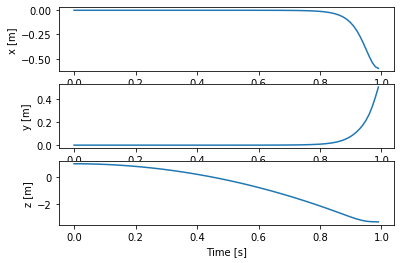

In [309]:
from scipy.integrate import odeint
from plotShrimp import plotOdeStates

def initialOdeState():
    r_w2b_w = np.array([0, 0, 1])
    vel_w2b_w = np.array([0, 0, 0])
    euler_w2f = np.array([0.01, 0.01, 0]) * np.pi/180.
    angvel_w2f_f = np.array([0, 0, 0])
    inflowVel = 0
    yaw_b2p = 0
    yaw_f2b = 0
    yawDot_f2b = rpm2RadiansPerSecond(10)
    yawDot_b2p = rpm2RadiansPerSecond(500)
    odeState = np.zeros(16)
    odeState[0:3] = r_w2b_w 
    odeState[3:6] = vel_w2b_w 
    odeState[6:9] = euler_w2f 
    odeState[9:12] = angvel_w2f_f 
    odeState[12] = yawDot_f2b 
    odeState[13] = yawDot_b2p 
    odeState[14] = yaw_f2b 
    odeState[15] = yaw_b2p
    return odeState

def runSimulation():
    y0 = initialOdeState()
    parameters = defaultShrimpParams()
    t = np.arange(0, 1, 0.01)
    states = odeint(flyerOde, y0, t, args=(parameters,))
    plotOdeStates(states, t)
    return (states,t)

(sol,t) = runSimulation()

    